# README
This notebook is a work in progress. This project is focused on bladder cancer segmentation.
In this notebook we construct the model, train and evaluate the performance of the model.

In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


# Set up Tensorboard
Currently we do not use this because it takes up too much RAM.

In [ ]:
# # Download Ngrok to tunnel the tensorboard port to an external port
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

# # Run tensorboard as well as Ngrox (for tunneling as non-blocking processes)
# import os
# import multiprocessing


# pool = multiprocessing.Pool(processes = 10)
# results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
#                         for cmd in [
#                         f"tensorboard --logdir ./logs/ --host 0.0.0.0 --port 6006 &",
#                         "./ngrok http 6006 &"
#                         ]]

In [ ]:
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# Importing the libraries

In [ ]:
!pip install pynrrd

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
%matplotlib inline

# Importing libraries needed for data processing
import os
import numpy as np
import nrrd
import tensorflow as tf
from numpy import load

# Adding a path
from pathlib import Path


# Necessary libraries for image alteration and animations
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from scipy import ndimage
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Keras
import os
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping , ReduceLROnPlateau
from keras import backend as keras
from keras import utils
from keras.utils import np_utils
from functools import partial
from keras import backend as K


# Importing needed libraries for constructing 3DUnet
from keras.layers import Input, LeakyReLU, Add, UpSampling3D, Activation, SpatialDropout3D, Conv3D,Conv3DTranspose,PReLU,Softmax,ReLU,Concatenate, MaxPooling3D 
from keras.engine import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.losses import categorical_crossentropy,mse
K.set_image_data_format("channels_last")

# Time
from tqdm.notebook import tqdm
import time
import datetime

# Visualization
import tensorboard

# Post-processing
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

# Loading the data

In [ ]:
# Training data

package = 'date5perpacient'
x_interm_train = load('../input/'+ package +'/x_first_batch.npz')
y_interm_train = load('../input/'+ package +'/y_first_batch.npz')

# Validation data
x_interm_valid = load('../input/'+ package +'/x_valid_first_batch.npz')
y_interm_valid = load('../input/'+ package +'/y_valid_first_batch.npz')

# Data from the second batch of patients
x_second = load('../input/'+ package +'/x_second_batch.npz')
y_second = load('../input/'+ package +'/y_second_batch.npz')

# Validation data from the second batch of patients
x_valid_second = load('../input/'+ package +'/x_valid_second_batch.npz')
y_valid_second = load('../input/'+ package +'/y_valid_second_batch.npz')

# Data from the second batch of patients
x_test = load('../input/'+ package +'/x_test.npz')
y_test = load('../input/'+ package +'/y_test.npz')


In [ ]:
x_train_first = x_interm_train['arr_0']
y_train_first = y_interm_train['arr_0']

x_valid_first = x_interm_valid['arr_0']
y_valid_first = y_interm_valid['arr_0']

x_train_second = x_second['arr_0']
y_train_second = y_second['arr_0']

x_valid_second = x_valid_second['arr_0']
y_valid_second = y_valid_second['arr_0']

x_test = x_test['arr_0']
y_test = y_test['arr_0']

In [ ]:
print('|---------------------------------------------|')
print('|           X          |           Y          |')
print('|----------------------|----------------------|')
print('|                First   batch                |')
print('|---------------------------------------------|')
print('|'+str(x_train_first.shape)+' |'+str(y_train_first.shape)+' |')
print('|'+str(x_valid_first.shape)+'  |'+str(y_valid_first.shape)+'  |')
print('|---------------------------------------------|')
print('|                 Second batch                |')
print('|---------------------------------------------|')
print('|'+str(x_train_second.shape)+' |'+str(y_train_second.shape)+' |')
print('|'+str(x_valid_second.shape)+'  | '+str(y_valid_second.shape)+' |')
print('|---------------------------------------------|')
print('|                    Test                     |')
print('|---------------------------------------------|')
print('| '+str(x_test.shape)+' | '+str(y_test.shape)+' |')
print('|---------------------------------------------|')

|---------------------------------------------|
|           X          |           Y          |
|----------------------|----------------------|
|                First   batch                |
|---------------------------------------------|
|(42, 128, 128, 32, 1) |(42, 128, 128, 32, 3) |
|(7, 128, 128, 32, 1)  |(7, 128, 128, 32, 3)  |
|---------------------------------------------|
|                 Second batch                |
|---------------------------------------------|
|(42, 128, 128, 32, 1) |(42, 128, 128, 32, 3) |
|(7, 128, 128, 32, 1)  | (7, 128, 128, 32, 3) |
|---------------------------------------------|
|                    Test                     |
|---------------------------------------------|
| (5, 128, 128, 32, 1) | (5, 128, 128, 32, 3) |
|---------------------------------------------|


In [ ]:
x_train_first = concatenate([x_train_first,x_train_second],axis=0)
y_train_first = concatenate([y_train_first,y_train_second],axis=0)

In [ ]:
x_valid_first = concatenate([x_valid_first,x_valid_second],axis=0)
y_valid_first = concatenate([y_valid_first,y_valid_second],axis=0)

# Vizualizing the data

In [ ]:
def ground_truth_visualize(x,nr):
    fig, ax = plt.subplots(1,3, figsize=[12, 12])
    img_org = x_train_first[nr][:,:,x]
    img_label_1 = y_train_first[nr][:,:,x,1]
    img_label_2 = y_train_first[nr][:,:,x,2]
    rotated_img = ndimage.rotate(img_org, 270)
    rotated_img_lb = ndimage.rotate(img_label_1, 270)
    rotated_img_lb_2 = ndimage.rotate(img_label_2, 270)
#     ax[0].set_title(" Original ")
    ax[0].imshow(rotated_img,cmap='gray')
    ax[0].axis('off')
#     ax[1].set_title("Segmentation Class 1")
    ax[1].imshow(rotated_img_lb,cmap='gray')
    ax[1].axis('off')
#     ax[2].set_title("Segmentation Class 2")
    ax[2].imshow(rotated_img_lb_2,cmap='gray')
    ax[2].axis('off')
    plt.show()

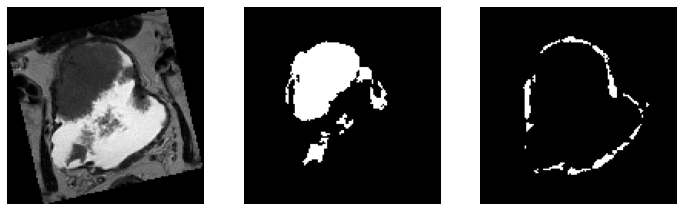

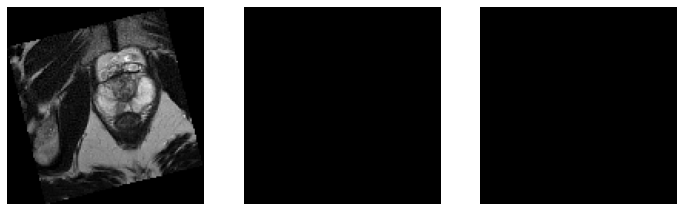

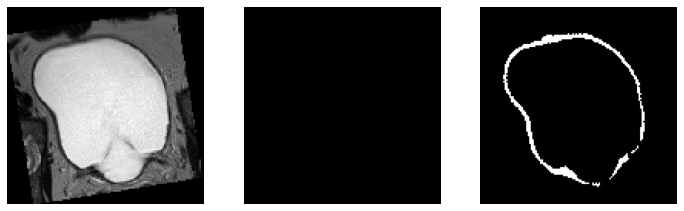

In [ ]:
ground_truth_visualize(10,15)
ground_truth_visualize(6,9)
ground_truth_visualize(15,19)

#### Shuffling the data

In [ ]:
def function_delete_surplus_data_nr(X,Y,nr):
  
    indexes = [i for i in range(X.shape[0])]
    indexes_2 = np.random.choice(indexes,size=nr,replace=False)

    x_l=[X[i] for i in indexes_2]
    y_l=[Y[i] for i in indexes_2]
    return x_l,y_l

In [ ]:
def function_shuffle(X,Y):
  
    indexes = [i for i in range(X.shape[0])]
    trainSample = np.random.choice(indexes,size=len(indexes),replace=False)

    x_train=[X[i] for i in trainSample]
    y_train=[Y[i] for i in trainSample]
    
    y_train = np.array(y_train)
    x_train = np.array(x_train)

    return x_train,y_train

In [ ]:
x_train_first, y_train_first = function_shuffle(x_train_first, y_train_first)

# Metrics and loss functions

Various loss function that we have tried and metrics for evaluating the performance of the model.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=3,weights=[0.1,0.4,0.5]):
    dice=0
    for index in range(numLabels):
        dice += weights[index]*dice_coef(y_true[:,index,:,:,:], y_pred[:,index,:,:,:])
    
    return 1-dice

def dice_coefficient_loss(y_true, y_pred, axis=(1, 2, 3), 
                     epsilon=0.00001):
    
    dice_numerator = 2*K.sum(y_true*y_pred,axis=(1,2,3))+epsilon
    dice_denominator = K.sum(y_true+y_pred,axis=(1,2,3))+epsilon
    dice_coefficient = K.mean(dice_numerator/dice_denominator)
   
    return 1-dice_coefficient

def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
   
    dice_numerator = 2.*K.sum(y_true*y_pred,axis=(0,1,2,3))+epsilon
    dice_denominator = K.sum(y_true*y_true + y_pred*y_pred,axis=(0,1,2,3))+epsilon
    
    dice_loss = 3 - K.sum(dice_numerator/dice_denominator)

    return dice_loss

# --- METRICS ---

def dice_coefficient(y_true, y_pred, smooth=1.):
    """
    Calcularea coeficientul DICE
    :param y_true:(3D Numpy Array) imaginea originala
    :param y_true:(3D Numpy Array) imaginea prezisa de model
    :returns:
    coeficientul DICE (float)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def auc(y_true, y_pred):
    smooth = 1
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + smooth) / (tp + fn + smooth) #recall
    tnr = (tn + smooth) / (tn + fp + smooth)
    prec = (tp + smooth) / (tp + fp + smooth) #precision
    return [tpr, tnr, prec]

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall


In [ ]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18

def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    # alpha - FP      beta - FN
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl - T



In [ ]:
def focal_loss_mean(y_true, y_pred,gamma=2., alpha=.25):

    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))

In [ ]:
def tanimoto_coefficient(y_true, y_pred, smooth=1.):
    """
    Calcularea coeficientul DICE
    :param y_true:(3D Numpy Array) imaginea originala
    :param y_true:(3D Numpy Array) imaginea prezisa de model
    :returns:
    coeficientul DICE (float)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

In [ ]:
def focal_loss_sum_mean(y_true, y_pred,gamma=2., alpha=.25):

    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

    return -K.sum(alpha * K.mean(K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon()),axis=(0,1,2,3))) - K.sum((1 - alpha) * K.mean(K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()),axis=(0,1,2,3)))


In [ ]:
def weighted_categorical_crossentropy(y_true,y_pred,weights=[1,10,5]):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    weights = K.variable(weights)
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

In [ ]:
def weighted_categorical_crossentropy_a(y_true,y_pred,weights=[1,10,5]):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.mean(loss)
    return loss

  

In [ ]:

def weighted_categorical_crossentropy_inverse(y_true,y_pred):
    #     A weighted version of keras.objectives.categorical_crossentropy
    """
     Variables:
         weights: numpy array of shape (C,) where C is the number of classes

     Usage:
         weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
         loss = weighted_categorical_crossentropy(weights)
         model.compile(loss=loss,optimizer='adam')
     """
    
    N = K.sum(K.ones(y_true.shape[1:-1]))
    N = tf.cast(N,tf.float32)
    
#     weights = K.variable(weights)

    weights = 1/K.sum(y_true,axis=(0,1,2,3))
    
    # scale predictions so that the class probas of each sample sum to 1
#     y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = K.sum(y_true * K.log(y_pred) * weights,axis=-1)
    loss = loss * 1/N
    # calc
    
    return -loss

In [ ]:
def weighted_categorical_crossentropy_median(y_true,y_pred):
    #     A weighted version of keras.objectives.categorical_crossentropy
    """
     Variables:
         weights: numpy array of shape (C,) where C is the number of classes

     Usage:
         weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
         loss = weighted_categorical_crossentropy(weights)
         model.compile(loss=loss,optimizer='adam')
     """
    
    N = K.sum(K.ones(y_true.shape[1:-1]))
    N = tf.cast(N,tf.float32)
    
    Fc = K.sum(y_true,axis=(0,1,2,3))/N
    medianFc= K.mean(Fc)
#     weights = K.variable(weights)

    weights = medianFc/Fc
    
    # scale predictions so that the class probas of each sample sum to 1
#     y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = K.sum(y_true * K.log(y_pred) * weights,axis=-1)
    
    loss = loss * 1/N
    # calc
    return - loss

In [ ]:
def weighted_categorical_crossentropy_focal(y_true,y_pred):
    """
     Variables:
         weights: numpy array of shape (C,) where C is the number of classes

     Usage:
         weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
         loss = weighted_categorical_crossentropy(weights)
         model.compile(loss=loss,optimizer='adam')
     """
    N = K.sum(K.ones(y_true.shape[1:-1]))
    N = tf.cast(N,tf.float32)

    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = K.sum(y_true * (1-y_pred) * (1-y_pred) * K.log(y_pred),axis=-1)

    loss = loss * 1/N
    # calc
    return - loss

In [ ]:
def ELL_Dice(y_true,y_pred,gamma=1):
    num = K.sum(2*y_true*y_pred + 1.,axis=(0,1,2,3))
    dem = K.sum(y_true+y_pred +1.,axis=(0,1,2,3))
    dice = num/dem
    dice = K.mean(K.pow(-K.log(dice),gamma))
    return dice

In [ ]:
def ELL(y_true,y_pred):
    weight = K.sum(y_pred,axis=(0,1,2,3))
    weight = weight/K.sum(y_true,axis=(0,1,2,3))
    T = K.mean(weight*y_true*K.log(y_pred))
    D = ELL_Dice(y_true,y_pred)
    return T + D

# Loading the model

In [ ]:
# dependencies = {
#     'dice_coefficient' : dice_coefficient,
#     'auc' : auc,
#     'confusion' : confusion,
#     'weighted_categorical_crossentropy': weighted_categorical_crossentropy
# }

# # # import tensorflow as tf
# # # mdel=tf.keras.models.load_model("../input/modele-antrenate/model_antrenat.h5",custom_objects=dependencies)

# import tensorflow as tf
# model_dc_unet = tf.keras.models.load_model("../input/150-epochs-bladder/model_sigmoid_nuclei.h5", custom_objects=dependencies)

# DC-Unet

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import initializers
from keras.layers import SpatialDropout3D, Input, Conv3D, MaxPooling3D, Conv3DTranspose, concatenate,AveragePooling3D, UpSampling3D, BatchNormalization, Activation, add, Dropout, Permute, ZeroPadding3D,Add, Reshape
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU, ReLU, PReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import applications, optimizers, callbacks
import matplotlib
import keras
import tensorflow as tf
from keras.layers import *

In [ ]:

def conv2d_bn(x, filters, num_row, num_col, num_z, padding='same', strides=(1, 1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv3D(filters, (num_row, num_col, num_z), strides=strides, padding=padding, use_bias=False)(x)
    
    if(activation == None):
        return x

    if (activation=='relu'):
        x = Activation('relu')(x)
    elif (activation=='prelu'):
        x = PReLU()(x)
        
    x = BatchNormalization(axis=4, scale=False)(x)
    
    return x


In [ ]:

def DCBlock3(U, inp, alpha = 1.67, activation='relu'):
    '''
    DC Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = U

    conv3x3_1 = conv2d_bn(inp, int(W*0.167), 3, 3,  3,
                        activation=activation, padding='same')

    conv5x5_1 = conv2d_bn(conv3x3_1, int(W*0.333), 3, 3, 3,
                        activation=activation, padding='same')

    conv7x7_1 = conv2d_bn(conv5x5_1, int(W*0.5), 3, 3, 3,
                        activation=activation, padding='same')

    out1 = concatenate([conv3x3_1, conv5x5_1, conv7x7_1], axis=4)
    out1 = BatchNormalization(axis=4)(out1)
    
    conv3x3_2 = conv2d_bn(inp, int(W*0.167), 3, 3, 3,
                        activation=activation, padding='same')

    conv5x5_2 = conv2d_bn(conv3x3_2, int(W*0.333), 3, 3, 3,
                        activation=activation, padding='same')

    conv7x7_2 = conv2d_bn(conv5x5_2, int(W*0.5), 3, 3, 3,
                        activation=activation, padding='same')
    
    out2 = concatenate([conv3x3_2, conv5x5_2, conv7x7_2], axis=4)
    out2 = BatchNormalization(axis=4)(out2)

    out = add([out1, out2])
    if (activation=='relu'):
        out = Activation('relu')(out)
    elif (activation=='prelu'):
        out = PReLU()(out)
                          
    out = BatchNormalization(axis=4)(out)

    return out

In [ ]:
def ResPath3(filters, length, inp, activation = 'relu'):
    '''
    ResPath
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''
    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1, 1,
                         activation=None, padding='same')
    
    out = conv2d_bn(inp, filters, 3, 3, 3, activation=activation, padding='same')
    
    out = add([shortcut, out])
    
    if (activation=='relu'):
        out = Activation('relu')(out)
    elif (activation=='prelu'):
        out = PReLU()(out)
        
    out = BatchNormalization(axis=4)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, 3, activation=activation, padding='same')

        out = add([shortcut, out])

        if (activation=='relu'):
            out = Activation('relu')(out)
        elif (activation=='prelu'):
            out = PReLU()(out)
            
        out = BatchNormalization(axis=4)(out)

    return out

In [ ]:
def DCUNet3(activation_middle = 'relu', loss_name = 'binary', input_size=(128, 128, 32, 1),  initial_learning_rate = 1e-4):
    '''
    DC-UNet
    
    Arguments:
        height {int} -- height of image 
        width {int} -- width of image 
        n_channels {int} -- number of channels in image
    
    Returns:
        [keras model] -- MultiResUNet model
    '''
    inputs = Input(input_size)

    dcblock1 = DCBlock3(32, inputs, activation = activation_middle)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(dcblock1)
    dcblock1 = ResPath3(32, 4, dcblock1, activation = activation_middle)

    dcblock2 = DCBlock3(32*2, pool1, activation = activation_middle)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(dcblock2)
    dcblock2 = ResPath3(32*2, 3, dcblock2, activation = activation_middle)

    dcblock3 = DCBlock3(32*4, pool2, activation = activation_middle)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(dcblock3)
    dcblock3 = ResPath3(32*4, 2, dcblock3)

    dcblock4 = DCBlock3(32*8, pool3, activation = activation_middle)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(dcblock4)
    dcblock4 = ResPath3(32*8, 1, dcblock4, activation = activation_middle)

    dcblock5 = DCBlock3(32*16, pool4, activation = activation_middle)

    up6 = concatenate([Conv3DTranspose(
        32*8, (2, 2, 2), strides=(2, 2, 2), padding='same')(dcblock5), dcblock4], axis=4)
    dcblock6 = DCBlock3(32*8, up6)

    up7 = concatenate([Conv3DTranspose(
        32*4, (2, 2, 2), strides=(2, 2, 2), padding='same')(dcblock6), dcblock3], axis=4)
    dcblock7 = DCBlock3(32*4, up7)

    up8 = concatenate([Conv3DTranspose(
        32*2, (2, 2, 2), strides=(2, 2, 2), padding='same')(dcblock7), dcblock2], axis=4)
    dcblock8 = DCBlock3(32*2, up8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(
        2, 2, 2), padding='same')(dcblock8), dcblock1], axis=4)
    dcblock9 = DCBlock3(32, up9, activation = activation_middle)
    
    outputs = Conv3D(3, (1, 1, 1), activation='softmax', name='output_1',padding='same')(dcblock9)
        
    model = Model(inputs=[inputs], outputs=[outputs])
    
    if loss_name == "categorical":
        model.compile(optimizer=Adam(lr=initial_learning_rate), loss = tf.keras.losses.categorical_crossentropy, metrics=['accuracy', auc, dice_coefficient, confusion, tanimoto_coefficient])
    elif loss_name == "weighted":
        model.compile(optimizer=Adam(lr=initial_learning_rate), loss = weighted_categorical_crossentropy, metrics=['accuracy', auc, dice_coefficient, confusion, tanimoto_coefficient])
    elif loss_name=="tversky":
        model.compile(optimizer=Adam(lr=initial_learning_rate), loss = tversky_loss, metrics=['accuracy', auc, dice_coefficient, confusion, tanimoto_coefficient])
        
    model.summary()
    return model

In [ ]:
model = DCUNet3(activation_middle = 'relu', loss_name = 'categorical')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 32, 135         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_3 (Conv3D)               (None, 128, 128, 32, 135         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32, 0           conv3d[0][0]                     
______________________________________________________________________________________________

# Antrenarea modelului

In [ ]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_tanimoto_coefficient',mode='max'),
        tf.keras.callbacks.ModelCheckpoint('model_sigmoid_nuclei.h5', monitor='val_tanimoto_coefficient',
                                           verbose=1, save_best_only=True,mode='max')
]

In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

In [ ]:
steps_per_epoch = int(np.ceil(x_train_first.shape[0] / 2))

In [ ]:
history2 = model.fit(x_train_first, y_train_first, validation_data = (x_valid_first, y_valid_first), epochs=50, batch_size=1, verbose=1, callbacks=callbacks)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/50
84/84 [==============================] - 281s 3s/step - loss: 1.2435 - accuracy: 0.3681 - auc: 0.4834 - dice_coefficient: 0.3379 - confusion: 0.3379 - tanimoto_coefficient: 0.2033 - val_loss: 1.0381 - val_accuracy: 0.9236 - val_auc: 0.3547 - val_dice_coefficient: 0.3549 - val_confusion: 0.3549 - val_tanimoto_coefficient: 0.2157

Epoch 00001: val_tanimoto_coefficient improved from -inf to 0.21574, saving model to model_sigmoid_nuclei.h5
Epoch 2/50
84/84 [==============================] - 274s 3s/step - loss: 1.0359 - accuracy: 0.8224 - auc: 0.5132 - dice_coefficient: 0.3598 - confusion: 0.3598 - tanimoto_coefficient: 0.2194 - val_loss: 0.9753 - val_accuracy: 0.9581 - val_auc: 0.6099 - val_dice_coefficient: 0.3777 - val_confusion: 0.3777 - val_tanimoto_coefficient: 0.2328

Epoch 00002: val_tanimoto_coefficient improved from 0.21574 to 0.23282, saving model to model_sigmoid_nuclei.h5
Epoch 3/50
84/84 [==============================] - 273s 3s/step - loss: 0.9711 - accuracy: 0.8

# Saving the model

In [ ]:
model.save('model.h5')

# Evolution Graphs

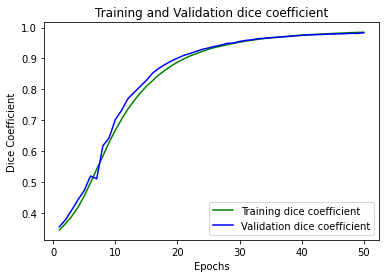

In [ ]:
loss_train = history2.history['dice_coefficient']
loss_val = history2.history['val_dice_coefficient']
nr_epochs = 50
epochs = range(1,nr_epochs+1)
plt.plot(epochs[:len(loss_train)], loss_train[:len(loss_train)], 'g', label='Training dice coefficient')
plt.plot(epochs[:len(loss_train)], loss_val[:len(loss_train)], 'b', label='Validation dice coefficient')
plt.title('Training and Validation dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

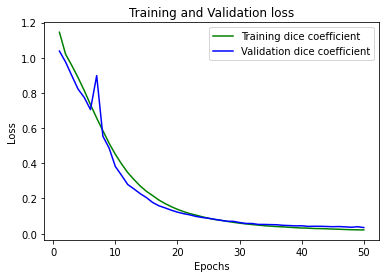

In [ ]:
loss_train_l = history2.history['loss']
loss_val_l = history2.history['val_loss']
nr_epochs = 50
epochs = range(1,nr_epochs+1)
plt.plot(epochs[:len(loss_train_l)], loss_train_l[:len(loss_train_l)], 'g', label='Training dice coefficient')
plt.plot(epochs[:len(loss_train_l)], loss_val_l[:len(loss_train_l)], 'b', label='Validation dice coefficient')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# loss_train = history_3.history['dice_coefficient']
# loss_val = history_3.history['val_dice_coefficient']
# nr_epochs = 20
# epochs = range(1,nr_epochs+1)
# plt.plot(epochs[:nr_epochs], loss_train[:nr_epochs], 'g', label='Training dice coefficient')
# plt.plot(epochs[:nr_epochs], loss_val[:nr_epochs], 'b', label='Validation dice coefficient')
# plt.title('Training and Validation dice coefficient')
# plt.xlabel('Epochs')
# plt.ylabel('Dice Coefficient')
# plt.legend()
# plt.show()

In [ ]:
# loss_train_l = history_3.history['loss']
# loss_val_l = history_3.history['val_loss']
# nr_epochs = 20
# epochs = range(1,nr_epochs+1)
# plt.plot(epochs[:nr_epochs], loss_train_l[:nr_epochs], 'g', label='Training loss')
# plt.plot(epochs[:nr_epochs], loss_val_l[:nr_epochs], 'b', label='Validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# loss_train = history_3.history['dice_coefficient']
# loss_val = history_3.history['val_dice_coefficient']
# nr_epochs = 40
# epochs = range(1,nr_epochs+1)
# plt.plot(epochs[:nr_epochs], loss_train[:nr_epochs], 'g', label='Training dice coefficient')
# plt.plot(epochs[:nr_epochs], loss_val[:nr_epochs], 'b', label='Validation dice coefficient')
# plt.title('Training and Validation dice coefficient')
# plt.xlabel('Epochs')
# plt.ylabel('Dice Coefficient')
# plt.legend()
# plt.show()

In [ ]:
# loss_train_l = history_3.history['loss']
# loss_val_l = history_3.history['val_loss']
# nr_epochs = 40
# epochs = range(1,nr_epochs+1)
# plt.plot(epochs[:nr_epochs], loss_train_l[:nr_epochs], 'g', label='Training loss')
# plt.plot(epochs[:nr_epochs], loss_val_l[:nr_epochs], 'b', label='Validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# Comparing

In [ ]:
def calculate_dice(y_true,y_pred):
    dice=dice_coefficient(y_true,y_pred)
    result=round(tf.keras.backend.get_value(dice),3)
    return result

In [ ]:
def choose_slice(patient):
    max_t_px = 0
    nr_slice = 0
    for x in range(patient.shape[2]):
        px = np.count_nonzero(patient[:,:,x,1] == 1)
        if px >= max_t_px:
            nr_slice = x
            max_t_px = px
    return nr_slice

In [ ]:
def choose_slice_best(patient,true):
    volume = np.copy(patient)
    max_dice = 0
    nr_slice = 0
    for z in range(patient.shape[2]):
        pat = np.copy(patient)
        dice, _ = automate_thrs(pat,true,z,1)
        px = np.count_nonzero(true[:,:,z,1] == 1)
        if dice>max_dice and px>0:
            max_dice = dice
            nr_slice = z
    return nr_slice

In [ ]:
def automate_thrs(volume,true,x,cls):
    thrs = [i/100 for i in range(100)]
    max_dice = 0
    thr_max = 0
    
    for t in thrs:
        patient = np.copy(volume)
        patient[:,:,x,cls] = np.where( patient[:,:,x,cls]>=t, 1, patient[:,:,x,cls])
        patient[:,:,x,cls] = np.where( patient[:,:,x,cls]<t, 0, patient[:,:,x,cls])
        dice = calculate_dice(true[:,:,x,cls],patient[:,:,x,cls])

        if dice>max_dice:
            thr_max = t
            max_dice = dice
    
    return max_dice, thr_max

In [ ]:
# predict_pacurar = model_unet_3d.predict(patients)
# predicted_labels_pacurar = np.copy(predict_pacurar)

In [ ]:
# def predicted_categorical_truth(nr,thr_w,thr_t):
#     fig, ax = plt.subplots(1,5, figsize=[8, 8])
# #     fig.suptitle('Predicted masks vs Ground truth', fontsize=16)
#     x = choose_slice(y_test[nr])
#     img_label_0 = patients[nr][:,:,x]
# #     img_label_1 = denoise_bilateral(predicted_labels_pacurar[nr][:,:,x,2], sigma_color=0.1, sigma_spatial=15)
# #     img_label_2 = denoise_bilateral(predicted_labels_pacurar[nr][:,:,x,1], sigma_color=0.01, sigma_spatial=20)
#     img_label_1 = predicted_labels_pacurar[nr][:,:,x,2]
#     img_label_2 = predicted_labels_pacurar[nr][:,:,x,1]
# #     img_label_1 = predicted_labels_pacurar[nr][:,:,x,2]
# #     img_label_2 = predicted_labels_pacurar[nr][:,:,x,1]
    
#     img_label_1_p = np.where(img_label_1>=thr_w,1,img_label_1)
#     img_label_1_p = np.where(img_label_1_p<thr_w,0,img_label_1_p)
#     img_label_2_p = np.where(img_label_2>=thr_t,1,img_label_2)
#     img_label_2_p = np.where(img_label_2_p<thr_t,0,img_label_2_p)
    
#     img_label_1 = img_label_1_p
#     img_label_2 = img_label_2_p

#     img_label_3=y_test[nr][:,:,x,1]
#     img_label_4=y_test[nr][:,:,x,2]
    
#     rotated_img_lb_0 = ndimage.rotate(img_label_0, 270)
#     rotated_img_lb_1 = ndimage.rotate(img_label_1, 270)
#     rotated_img_lb_2 = ndimage.rotate(img_label_2, 270)
#     rotated_img_lb_3 = ndimage.rotate(img_label_3, 270)
#     rotated_img_lb_4 = ndimage.rotate(img_label_4, 270)
    
# #     prediction = predicted_labels_pacurar[nr]
    
#     dice_p,dice_t = slice_calculate_dice(predicted_labels_pacurar[nr], y_test[nr], x, thr_w, thr_t)
#     dice_p = round(tf.keras.backend.get_value(dice_p),3)
#     dice_t = round(tf.keras.backend.get_value(dice_t),3)
    
#     ax[0].imshow(rotated_img_lb_0,cmap='gray')
#     ax[0].axis('off')
#     ax[1].set_title("    DSC for wall: "+str(dice_p))
#     ax[1].imshow(rotated_img_lb_4,cmap='gray')
#     ax[1].axis('off')
# #     ax[0][1].set_title("Dice value for wall: "+str(dice_p))
#     ax[2].imshow(rotated_img_lb_1,cmap='gray')
#     ax[2].axis('off')
#     ax[3].set_title("       DSC for tumor: "+str(dice_t))
#     ax[3].imshow(rotated_img_lb_3,cmap='gray')
#     ax[3].axis('off')
#     ax[4].imshow(rotated_img_lb_2,cmap='gray')
#     ax[4].axis('off')
#     plt.tight_layout()
#     plt.show()

In [ ]:
# def predicted_categorical_truth(nr,thr_w=0.1,thr_t=0.1,thr_b=0.001):
#     fig, ax = plt.subplots(1,7, figsize=[8, 8])
#     x = choose_slice(y_test[nr])
#     img_label_0 = patients[nr][:,:,x]
# #     img_label_1 = denoise_bilateral(predicted_labels_pacurar[nr][:,:,x,2], sigma_color=0.1, sigma_spatial=15)
# #     img_label_2 = denoise_bilateral(predicted_labels_pacurar[nr][:,:,x,1], sigma_color=0.01, sigma_spatial=20)
#     img_label_2 = np.copy(predicted_labels_pacurar[nr][:,:,x,2])
#     img_label_4 = np.copy(predicted_labels_pacurar[nr][:,:,x,1])
#     img_label_6 = np.copy(predicted_labels_pacurar[nr][:,:,x,0])
# #     img_label_1 = predicted_labels_pacurar[nr][:,:,x,2]
# #     img_label_2 = predicted_labels_pacurar[nr][:,:,x,1]
    
#     img_label_2_p = np.where(img_label_2>=thr_w,1,img_label_2)
#     img_label_2_p = np.where(img_label_2_p<thr_w,0,img_label_2_p)
#     img_label_4_p = np.where(img_label_4>=thr_t,1,img_label_4)
#     img_label_4_p = np.where(img_label_4_p<thr_t,0,img_label_4_p)
#     img_label_6_p = np.where(img_label_6>=0.8,1,img_label_6)
#     img_label_6_p = np.where(img_label_6_p<0.8,0,img_label_6_p)
    
#     img_label_2 = img_label_2_p
#     img_label_4 = img_label_4_p
#     img_label_6 = img_label_6_p

#     img_label_1=y_test[nr][:,:,x,2]
#     img_label_3=y_test[nr][:,:,x,1]
#     img_label_5=y_test[nr][:,:,x,0]
    
#     rotated_img_lb_0 = ndimage.rotate(img_label_0, 270)
#     rotated_img_lb_1 = ndimage.rotate(img_label_1, 270)
#     rotated_img_lb_2 = ndimage.rotate(img_label_2, 270)
#     rotated_img_lb_3 = ndimage.rotate(img_label_3, 270)
#     rotated_img_lb_4 = ndimage.rotate(img_label_4, 270)
#     rotated_img_lb_5 = ndimage.rotate(img_label_5, 270)
#     rotated_img_lb_6 = ndimage.rotate(img_label_6, 270)
    
# #     prediction = predicted_labels_pacurar[nr]
    
#     dice_p, dice_t, dice_b = slice_calculate_dice(predicted_labels_pacurar[nr], y_test[nr], x, thr_w, thr_t, thr_b)
#     dice_p = round(tf.keras.backend.get_value(dice_p),3)
#     dice_t = round(tf.keras.backend.get_value(dice_t),3)
    
#     ax[0].imshow(rotated_img_lb_0,cmap='gray')
#     ax[0].axis('off')
#     ax[1].set_title("    DSC for wall: "+str(dice_p))
#     ax[1].imshow(rotated_img_lb_1,cmap='gray')
#     ax[1].axis('off')
# #     ax[0][1].set_title("Dice value for wall: "+str(dice_p))
#     ax[2].imshow(rotated_img_lb_2,cmap='gray')
#     ax[2].axis('off')
#     ax[3].set_title("       DSC for tumor: "+str(dice_t))
#     ax[3].imshow(rotated_img_lb_3,cmap='gray')
#     ax[3].axis('off')
#     ax[4].imshow(rotated_img_lb_4,cmap='gray')
#     ax[4].axis('off')
#     ax[5].set_title("       DSC for bg: "+str(dice_b))
#     ax[5].imshow(rotated_img_lb_5,cmap='gray')
#     ax[5].axis('off')
#     ax[6].imshow(rotated_img_lb_6,cmap='gray')
#     ax[6].axis('off')
#     plt.tight_layout()
#     plt.show()

In [ ]:
def predicted_categorical_truth(fname, thr_w=0.1,thr_t=0.1,thr_b=0.9):
    fig, ax = plt.subplots(5,7, figsize=[8, 8])
    
#     x = choose_slice(y_test[nr])
    for i in range(5):
        x = choose_slice_best(predicted_labels_pacurar[i], y_test[i])
        img_label_0 = patients[i][:,:,x]
        img_label_1=y_test[i][:,:,x,2]
        img_label_3=y_test[i][:,:,x,1]
        img_label_5=y_test[i][:,:,x,0]

        img_label_2 = np.copy(predicted_labels_pacurar[i][:,:,x,2])
        img_label_4 = np.copy(predicted_labels_pacurar[i][:,:,x,1])
        img_label_6 = np.copy(predicted_labels_pacurar[i][:,:,x,0])


        dice_b, thr_b = automate_thrs(predicted_labels_pacurar[i],y_test[i],x,0)
        dice_p, thr_w = automate_thrs(predicted_labels_pacurar[i],y_test[i],x,2)
        dice_t, thr_t = automate_thrs(predicted_labels_pacurar[i],y_test[i],x,1)

        img_label_2_p = np.where(img_label_2>=thr_w,1,img_label_2)
        img_label_2_p = np.where(img_label_2_p<thr_w,0,img_label_2_p)
        img_label_4_p = np.where(img_label_4>=thr_t,1,img_label_4)
        img_label_4_p = np.where(img_label_4_p<thr_t,0,img_label_4_p)
        img_label_6_p = np.where(img_label_6>=thr_b,1,img_label_6)
        img_label_6_p = np.where(img_label_6_p<thr_b,0,img_label_6_p)

        img_label_2 = img_label_2_p
        img_label_4 = img_label_4_p
        img_label_6 = img_label_6_p


        rotated_img_lb_0 = ndimage.rotate(img_label_0, 270)
        rotated_img_lb_1 = ndimage.rotate(img_label_1, 270)
        rotated_img_lb_2 = ndimage.rotate(img_label_2, 270)
        rotated_img_lb_3 = ndimage.rotate(img_label_3, 270)
        rotated_img_lb_4 = ndimage.rotate(img_label_4, 270)
        rotated_img_lb_5 = ndimage.rotate(img_label_5, 270)
        rotated_img_lb_6 = ndimage.rotate(img_label_6, 270)


        dice_b = round(tf.keras.backend.get_value(dice_b),3)
        dice_p = round(tf.keras.backend.get_value(dice_p),3)
        dice_t = round(tf.keras.backend.get_value(dice_t),3)

        ax[i][0].imshow(rotated_img_lb_0,cmap='gray')
        ax[i][0].axis('off')
        ax[i][1].set_title("    DSC for wall: "+str(dice_p))
        ax[i][1].imshow(rotated_img_lb_1,cmap='gray')
        ax[i][1].axis('off')
    #     ax[0][1].set_title("Dice value for wall: "+str(dice_p))
        ax[i][2].imshow(rotated_img_lb_2,cmap='gray')
        ax[i][2].axis('off')
        ax[i][3].set_title("       DSC for tumor: "+str(dice_t))
        ax[i][3].imshow(rotated_img_lb_3,cmap='gray')
        ax[i][3].axis('off')
        ax[i][4].imshow(rotated_img_lb_4,cmap='gray')
        ax[i][4].axis('off')
        ax[i][5].set_title("       DSC for bg: "+str(dice_b))
        ax[i][5].imshow(rotated_img_lb_5,cmap='gray')
        ax[i][5].axis('off')
        ax[i][6].imshow(rotated_img_lb_6,cmap='gray')
        ax[i][6].axis('off')
    plt.tight_layout()
    plt.show()
    plt.savefig(fname)


In [ ]:
def slice_calculate_dice(vol_pred, vol_true, x, thr_w, thr_t, thr_b):
    prediction = np.copy(vol_pred)
    prediction[:,:,x,2] = np.where(prediction[:,:,x,2]>=thr_w,1,prediction[:,:,x,2])
    prediction[:,:,x,2] = np.where(prediction[:,:,x,2]<thr_w,0,prediction[:,:,x,2])
    prediction[:,:,x,1] = np.where(prediction[:,:,x,1]>=thr_t,1,prediction[:,:,x,1])
    prediction[:,:,x,1] = np.where(prediction[:,:,x,1]<thr_t,0,prediction[:,:,x,1])
    prediction[:,:,x,0] = np.where(prediction[:,:,x,0]>=thr_b,1,prediction[:,:,x,0])
    prediction[:,:,x,0] = np.where(prediction[:,:,x,0]<thr_b,0,prediction[:,:,x,0])

    dice_b = calculate_dice(vol_true[:,:,x,0], prediction[:,:,x,0])
    dice_t = calculate_dice(vol_true[:,:,x,1], prediction[:,:,x,1])
    dice_p = calculate_dice(vol_true[:,:,x,2], prediction[:,:,x,2])
    return dice_p, dice_t, dice_b


In [ ]:
def slice_calculate_dice_updated(vol_pred, vol_true, x, thr_w, thr_t, thr_b):
    prediction = np.copy(vol_pred)
    prediction[:,:,x,2] = np.where(prediction[:,:,x,2]>=prediction[:,:,x,1] and prediction[:,:,x,2]>=prediction[:,:,x,0],1,prediction[:,:,x,2])
    prediction[:,:,x,2] = np.where(prediction[:,:,x,2]!=1,0,prediction[:,:,x,2])
    prediction[:,:,x,1] = np.where(prediction[:,:,x,1]>=prediction[:,:,x,2] and prediction[:,:,x,1]>=prediction[:,:,x,0],1,prediction[:,:,x,1])
    prediction[:,:,x,1] = np.where(prediction[:,:,x,1]!=1,0,prediction[:,:,x,1])
    prediction[:,:,x,0] = np.where(prediction[:,:,x,0]>=prediction[:,:,x,2] and prediction[:,:,x,0]>=prediction[:,:,x,1],1,prediction[:,:,x,0])
    prediction[:,:,x,0] = np.where(prediction[:,:,x,0]!=1,0,prediction[:,:,x,0])

    dice_b = calculate_dice(vol_true[:,:,x,0], prediction[:,:,x,0])
    dice_t = calculate_dice(vol_true[:,:,x,1], prediction[:,:,x,1])
    dice_p = calculate_dice(vol_true[:,:,x,2], prediction[:,:,x,2])
    return dice_p, dice_t, dice_b


In [ ]:
# dependencies = {
#     'dice_coefficient' : dice_coefficient,
#     'auc' : auc,
#     'confusion' : confusion,
#     'weighted_categorical_crossentropy': weighted_categorical_crossentropy
# }

# # # import tensorflow as tf
# # # mdel=tf.keras.models.load_model("../input/modele-antrenate/model_antrenat.h5",custom_objects=dependencies)

# import tensorflow as tf
# model_dc_unet = tf.keras.models.load_model("../input/150-epochs-bladder/model_sigmoid_nuclei.h5", custom_objects=dependencies)

In [ ]:
patients = x_test
labels = y_test

In [ ]:
predict_pacurar = model.predict(patients)
predicted_labels_pacurar = np.copy(predict_pacurar)

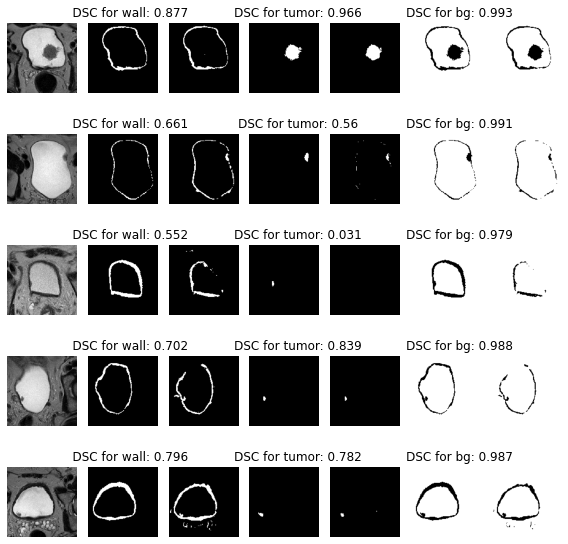

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_categorical_truth("DC-Unet_50epochs.jpg")

In [ ]:
def volume_calculate_dice(vol_pred,vol_true, thr_w=0.1, thr_t=0.1, thr_b=0.8):
    dice_p = 0
    dice_t = 0
    dice_b = 0
    for z in range(vol_pred.shape[2]):
        patient = np.copy(vol_pred)
        dice_b_z, thr_b = automate_thrs(patient,vol_true,z,0)
        dice_p_z, thr_w = automate_thrs(patient,vol_true,z,2)
        dice_t_z, thr_t = automate_thrs(patient,vol_true,z,1)

        dice_p += dice_p_z
        dice_t += dice_t_z
        dice_b += dice_b_z
    return dice_p/vol_pred.shape[2], dice_t/vol_pred.shape[2], dice_b/vol_pred.shape[2]

def total_dice(list_vol_pred,list_vol_true,thr_w=0.1, thr_t=0.1, thr_b=0.8):
    d_p = 0
    d_t = 0
    d_b = 0
    for i in range(len(list_vol_pred)):
        d_p_i,d_t_i,d_b_i = volume_calculate_dice(list_vol_pred[i],list_vol_true[i], thr_w, thr_t, thr_b)
        d_p += d_p_i
        d_t += d_t_i
        d_b += d_b_i
    return d_p/len(list_vol_pred),d_t/len(list_vol_pred),d_b/len(list_vol_pred)

In [ ]:
d_p, d_t, d_b = total_dice(predicted_labels_pacurar,y_test,0.1,0.1)
print("epochs 40: wall: "+ str(d_p)+" tumor: "+str(d_t)+ " bg: "+ str(d_b))

epochs 40: wall: 0.7681249989385833 tumor: 0.9210500000976026 bg: 0.9945875000208616


In [ ]:
print("medie: " + str((d_p + d_t + d_b)/3))

medie: 0.8945874996856825


In [ ]:
dependencies = {
    'dice_coefficient' : dice_coefficient,
    'auc' : auc,
    'confusion' : confusion,
    'weighted_categorical_crossentropy': weighted_categorical_crossentropy
}

# # import tensorflow as tf
# # mdel=tf.keras.models.load_model("../input/modele-antrenate/model_antrenat.h5",custom_objects=dependencies)

import tensorflow as tf
model_dc_unet_3d=tf.keras.models.load_model("../input/40-epochs/model_sigmoid_nuclei.h5", custom_objects=dependencies)

In [ ]:
predict_pacurar = model_dc_unet_3d.predict(patients)
predicted_labels_pacurar = np.copy(predict_pacurar)

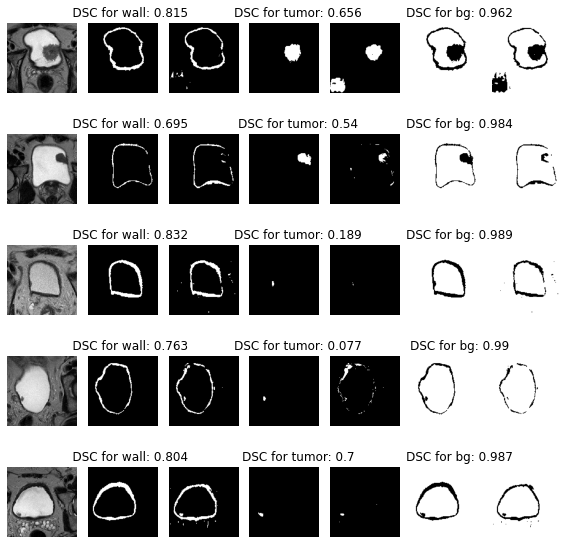

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_categorical_truth("DC-UNet-40epochs.jpg")

In [ ]:
d_p, d_t, d_b = total_dice(predicted_labels_pacurar,y_test,0.1,0.1)
print("epochs 40: wall: "+ str(d_p)+" tumor: "+str(d_t)+ " bg: "+ str(d_b))

epochs 40: wall: 0.8276937498740153 tumor: 0.8139500002434943 bg: 0.993775000050664


In [ ]:
print("medie: " + str((d_p+d_t+d_b)/3))

medie: 0.8784729167227244
